## Load Libraries

In [1]:
import os,glob
from skimage import io,transform
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
import numpy as np
import re
from time import time
from sklearn.decomposition import IncrementalPCA
from skimage.color import rgb2gray
from sklearn.metrics import classification_report
%matplotlib inline

In [2]:
symbols=' prbnkqPRBNKQ' #piece symbols

In [3]:
#To reduct problem complexity, 
#we turn the problem into pieces type classification 
#through dividing chess borad into 64 lattices 
def seg_image(img,label):
    label=label.replace('-','')
    subimg=list()
    sublabel=list()
    for char in label:
        if char.isdigit():
            for _ in range(int(char)):
                encoder=symbols.index(' ')
                sublabel.append(encoder)
        else:
            encoder=symbols.index(char)
            sublabel.append(encoder)
    for idx_i,i in enumerate(range(0,200,25)):
        for idx_j,j in enumerate(range(0,200,25)):
            subimg.append(img[i:i+25,j:j+25])
    return subimg,sublabel

In [4]:
train_path ="./chess/dataset/train/*.jpeg"
test_path ="./chess/dataset/test/*.jpeg"

## Split dataset

In [5]:
fns=glob.glob(train_path)
np.random.shuffle(fns)# shuffle train data
train_fn=fns[0:4000]# 4000 samples
val_fn=fns[4000:6000]#2000 samples
test_fn=glob.glob(test_path)
np.random.shuffle(test_fn)
test_fn=test_fn[:4000]#4000 samples

## Data pre-processing

In [6]:
def callbackfn(x):
    x=transform.rescale(io.imread(x),0.5,multichannel=True) #rescale images to 200x200
    x=rgb2gray(x) #convert RGB images to gray
    x=x/255 #normalize matrix 
    return x
#we make use of generator to save memory to avoid memory error
train_images=(x for x in io.ImageCollection(train_fn,load_func=callbackfn))
train_labels=map(lambda x: x[22:-5],train_fn)
val_images=(x for x in io.ImageCollection(val_fn,load_func=callbackfn))
val_labels=map(lambda x: x[22:-5],val_fn)
test_images=(x for x in io.ImageCollection(test_fn,load_func=callbackfn))
test_labels=map(lambda x: x[21:-5],test_fn)

In [7]:
# convert list containing image into array in batch
def get_minibatch(images,labels,batch_size,seg_func):
    x=list()
    y=list()
    for image,label in zip(itertools.islice(images, batch_size),itertools.islice(labels, batch_size)):
        subimgs,sublabels=seg_func(image,label)
        for subimg,sublabel in zip(subimgs,sublabels):
            x.append(subimg.reshape(subimg.shape[0]*subimg.shape[1]))
            y.append(sublabel)
    x=np.array(x)
    y=np.array(y)
    return x,y
def get_batch(images,labels,batch_size,seg_func):
    x,y=get_minibatch(images,labels,batch_size,seg_func)
    while len(x):
        yield x,y
        x,y=get_minibatch(images,labels,batch_size,seg_func)

In [8]:
batch_size=2000
train_size=len(train_fn)
val_size=len(val_fn)
test_size=len(test_fn)
n_components=30

In [9]:
#acquire data batches
train_bchs= get_batch(train_images,train_labels,batch_size=batch_size,seg_func=seg_image)
val_bchs=get_batch(val_images,val_labels,batch_size=batch_size,seg_func=seg_image)
test_bchs=get_batch(test_images,test_labels,batch_size=batch_size,seg_func=seg_image)
x_train=np.ndarray(shape=(0,n_components))
y_train=np.ndarray(shape=(0,),dtype=int)
x_val=np.ndarray(shape=(0,n_components))
y_val=np.ndarray(shape=(0,),dtype=int)
x_test=np.ndarray(shape=(0,n_components))
y_test=np.ndarray(shape=(0,),dtype=int)

### Incremental PCA

In [10]:
# we use IncrementalPCA to fit model with data in batch
print('Start PCA fitting...\n')
for epoch,(_x_train_,_y_train_) in enumerate(train_bchs):
    start=time()
    pca=IncrementalPCA(n_components=n_components)
    pca.partial_fit(_x_train_)
    x_train=np.vstack((x_train, pca.transform(_x_train_)))
    y_train=np.concatenate((y_train,_y_train_))
    end=time()
    print('Partial fit of {} out of {}.Cost:{}s'.format((epoch+1)*batch_size, train_size,end-start))
print('Start transforming test set...')
print('------------------------------------')
for epoch,(_x_test_,_y_test_) in enumerate(test_bchs):
    start=time()
    x_test=np.vstack((x_test, pca.transform(_x_test_)))
    y_test=np.concatenate((y_test,_y_test_))
    end=time()
    print('Partial transform of {} out of {}.Cost:{}s'.format((epoch+1)*batch_size, test_size,end-start))
print('Start transforming validation set...')
print('------------------------------------')
for epoch,(_x_val_,_y_val_) in enumerate(val_bchs):
    start=time()
    pca=IncrementalPCA(n_components=n_components)
    pca.partial_fit(_x_val_)
    x_val=np.vstack((x_val, pca.transform(_x_val_)))
    y_val=np.concatenate((y_val,_y_val_))
    end=time()
    print('Partial transform of {} out of {}.Cost:{}s'.format((epoch+1)*batch_size, val_size,end-start))

Start PCA fitting...

Partial fit of 2000 out of 4000.Cost:16.346176385879517s
Partial fit of 4000 out of 4000.Cost:14.250976085662842s
Start transforming test set...
------------------------------------
Partial transform of 2000 out of 4000.Cost:0.6565678119659424s
Partial transform of 4000 out of 4000.Cost:0.6279506683349609s
Start transforming validation set...
------------------------------------
Partial transform of 2000 out of 2000.Cost:16.830342769622803s


In [11]:
print(x_train.shape,x_val.shape,x_test.shape)

(256000, 30) (128000, 30) (256000, 30)


### Hyperparameter Tuning

In [19]:
#KNN
# set parameter n_jobs as 4 to parallize, whcih means using 4 processors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
start=time()
parameters={'n_neighbors':range(1,20)}
clf_knn=KNeighborsClassifier()
clf_knn = GridSearchCV(clf_knn, parameters,verbose =1,n_jobs =4,cv=3)
clf_knn.fit(x_train,y_train)

Fitting 3 folds for each of 19 candidates, totalling 57 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  57 out of  57 | elapsed:  2.8min finished


best params of KNN:
 {'n_neighbors': 1}


In [21]:
print('best params of KNN:\n', clf_knn.best_params_)

best params of KNN:
 {'n_neighbors': 1}


### Evaluation 

In [14]:
##Ten-fola cross validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
def acc_gen(predictions,label): #calculate accuracy
    cor=0
    for x in np.arange(0,len(predictions),64):
        if np.mean(predictions[x:(x+64)]==label[x:(x+64)])==1:
            cor+=1
    return cor/(len(predictions)/64)
kf = KFold(n_splits=10,shuffle=True)
#Acc={'KNN':[],'RandomForest':[],'GaussianNB':[]}
Acc={'accuracy':[],'time':[]}
for idx_train, idx_test in kf.split(x_val):
    start=time()
    X_train, X_test = x_val[idx_train], x_val[idx_test]
    Y_train, Y_test = y_val[idx_train], y_val[idx_test]
    knn=KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,Y_train)
    preds_knn=knn.predict(X_test)
    end=time()
    print('Cost:{}s'.format(end-start))
    accuracy=acc_gen(preds_knn,Y_test)
    Acc['accuracy'].append(accuracy)
    Acc['time'].append(round(end-start,2))
print('Average accuracy : ',np.mean(Acc['accuracy']))
print('Average cost time: ',np.mean(Acc['time']))

Cost:1.2176694869995117s
Cost:1.9290263652801514s
Cost:1.6681170463562012s
Cost:1.534250259399414s
Cost:1.715388536453247s
Cost:2.0825321674346924s
Cost:1.9817161560058594s
Cost:1.759598970413208s
Cost:1.1989083290100098s
Cost:1.4889986515045166s
Average accuracy :  0.966
Average cost time:  1.658


In [20]:
Acc# Accuracy and running time of Ten-fold CV

{'accuracy': [0.975,
  0.955,
  0.98,
  0.965,
  0.965,
  0.965,
  0.94,
  0.96,
  0.975,
  0.98],
 'time': [1.22, 1.93, 1.67, 1.53, 1.72, 2.08, 1.98, 1.76, 1.2, 1.49]}

### Classification for test set

Cost:21.44062638282776s
Accuracy: 0.987
              precision    recall  f1-score   support

                   1.00      1.00      1.00    216144
           p       1.00      1.00      1.00      3548
           r       1.00      1.00      1.00      3630
           b       1.00      1.00      1.00      3477
           n       1.00      1.00      1.00      3465
           k       1.00      1.00      1.00      4000
           q       1.00      0.99      0.99      1737
           P       1.00      1.00      1.00      3678
           R       1.00      1.00      1.00      3497
           B       1.00      1.00      1.00      3508
           N       1.00      1.00      1.00      3566
           K       1.00      1.00      1.00      4000
           Q       1.00      1.00      1.00      1750

    accuracy                           1.00    256000
   macro avg       1.00      1.00      1.00    256000
weighted avg       1.00      1.00      1.00    256000



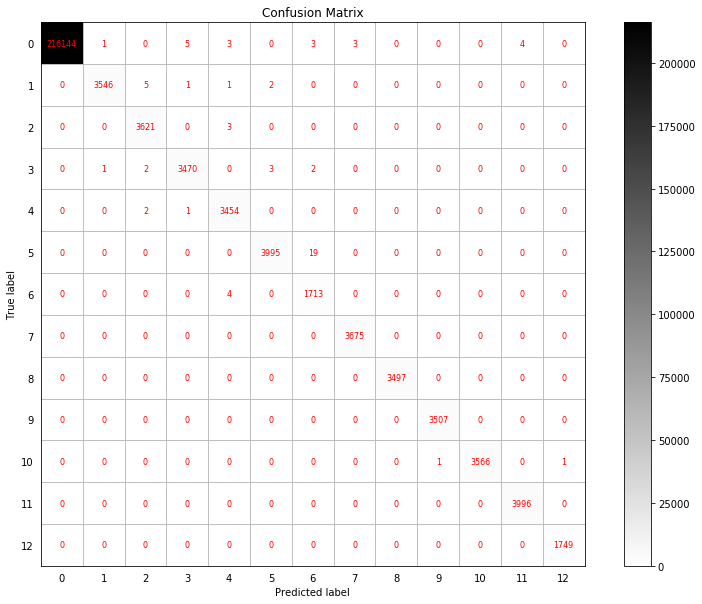

In [18]:
#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
start=time()
knn=KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train,y_train)
preds_knn=knn.predict(x_test)
end=time()
print('Cost:{}s'.format(end-start))
accuracy=acc_gen(preds_knn,y_test)
print('Accuracy:',accuracy)
print(classification_report(y_test,preds_knn,target_names=[x for x in symbols]))
cm=confusion_matrix(y_test,preds_knn)

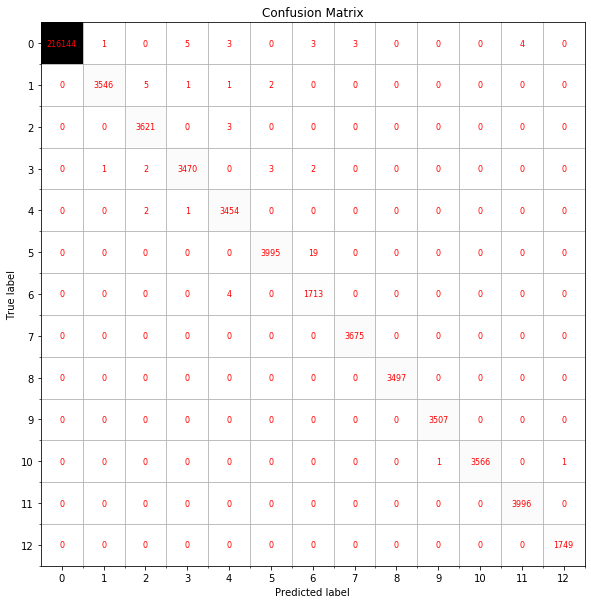

In [22]:
def plot_cm(cm):
    plt.figure(figsize=(14,10))#set figure size
    plt.xticks(range(13), range(13))
    plt.yticks(range(14), range(14))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    idx = np.arange(13)
    x, y = np.meshgrid(idx, idx)
    for xIdx, yIdx in zip(x.flatten(), y.flatten()):
        c = cm[xIdx][yIdx]
        plt.text(xIdx, yIdx, c
                 , color='red'
                 , va='center'
                 , ha='center'
                 , fontsize=8)#place number in the center of each square grid
    
    tick_marks = np.array(range(13)) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.grid(True, which='minor', linestyle='-')
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.binary)
    plt.title('Confusion Matrix')
plot_cm(cm)